# Posterior Predictive Checks

Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior. 

Elaborating slightly, one can say that PPCs analyze the degree to which data generated from the model deviate from data generated from the true distribution. So often you will want to know if, for example, your posterior distribution is approximating your underlying distribution. The visualization aspect of this model evaluation method is also great for a 'sense check' or explaining your model to others and getting criticism. 

Here we will implement a general routine to draw samples from the observed nodes of a model.

In [1]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as st

plt.style.use('seaborn-darkgrid')
print('Running with PyMC3 version v.{}'.format(pm.__version__))

Running with PyMC3 version v.3.4.1


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Lets generate a very simple model:

In [2]:
data = np.random.randn(100)

with pm.Model() as model: 
    mu = pm.Normal('mu', mu=0, sd=1, testval=0)
    sd = pm.HalfNormal('sd', sd=1)
    n = pm.Normal('n', mu=mu, sd=sd, observed=data)
    
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:09<00:00, 1203.56draws/s]


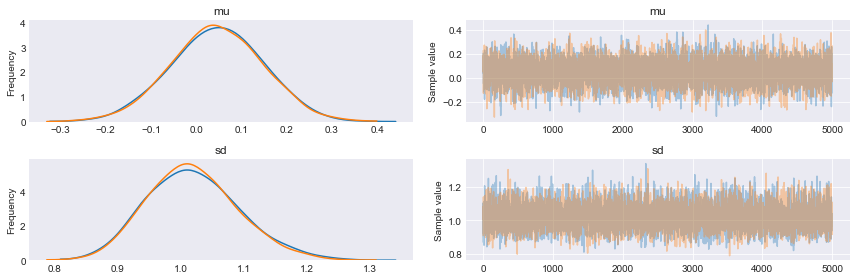

In [3]:
pm.traceplot(trace);

This function will randomly draw 500 samples of parameters from the trace. Then, for each sample, it will draw 100 random numbers from a normal distribution specified by the values of `mu` and `std` in that sample.

In [4]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=model)

100%|██████████| 500/500 [00:00<00:00, 1003.00it/s]


Now, `ppc` contains 500 generated data sets (containing 100 samples each), each using a different parameter setting from the posterior:

In [5]:
np.asarray(ppc['n']).shape

(500, 100)

One common way to visualize is to look if the model can reproduce the patterns observed in the real data. For example, how close are the inferred means to the actual sample mean:

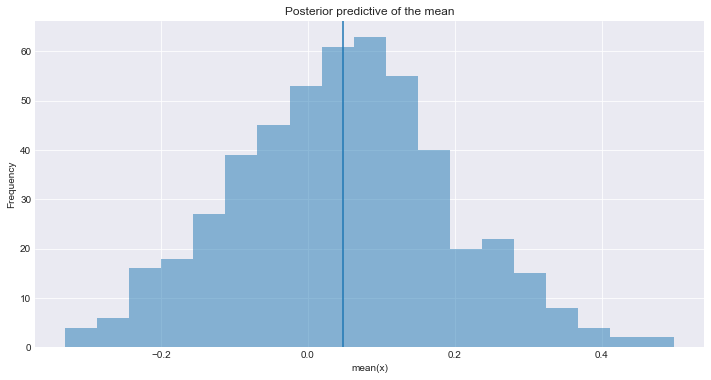

In [6]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc['n']], bins=19, alpha=0.5)
ax.axvline(data.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

## Comparison between PPC and other model evaluation methods. 

An excellent introduction to this was given in the [Edward](http://edwardlib.org) documentation:

> PPCs are an excellent tool for revising models, simplifying or expanding the current model as one examines how well it fits the data. They are inspired by prior checks and classical hypothesis testing, under the philosophy that models should be criticized under the frequentist perspective of large sample assessment.

> PPCs can also be applied to tasks such as hypothesis testing, model comparison, model selection, and model averaging. It’s important to note that while they can be applied as a form of Bayesian hypothesis testing, hypothesis testing is generally not recommended: binary decision making from a single test is not as common a use case as one might believe. We recommend performing many PPCs to get a holistic understanding of the model fit.

## Prediction

The same pattern can be used for prediction. Here we're building a logistic regression model. Note that since we are dealing the full posterior, we are also getting uncertainty in our predictions for free.

In [7]:
# Use a theano shared variable to be able to exchange the data the model runs on
from theano import shared

In [8]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

n = 4000
coeff = 1.

predictors = np.random.normal(size=n)
# Turn predictor into a shared var so that we can change it later
predictors_shared = shared(predictors)

outcomes = np.random.binomial(1, invlogit(coeff * predictors))

In [9]:
outcomes

array([0, 1, 0, ..., 1, 1, 1])

In [10]:
predictors_out_of_sample = np.random.normal(size=50)
outcomes_out_of_sample = np.random.binomial(1, invlogit(coeff * predictors_out_of_sample))

In [11]:
with pm.Model() as model:
    coeff = pm.Normal('coeff', mu=0, sd=1)
    outcome = pm.Bernoulli('outcome', logit_p=coeff*predictors_shared, observed=outcomes)    
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [coeff]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:12<00:00, 904.94draws/s] 


In [12]:
# Changing values here will also change values in the model
predictors_shared.set_value(predictors_out_of_sample)

In [13]:
# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_posterior_predictive(trace, model=model, samples=100)

100%|██████████| 100/100 [00:01<00:00, 87.67it/s]


### Mean predicted values plus error bars to give sense of uncertainty in prediction

Note that these are uncertainty caused by MCMC estimation, and not from the underlying model.  If we had taken more samples in `sample_posterior_predictive`, the error bars would get smaller quite quickly.

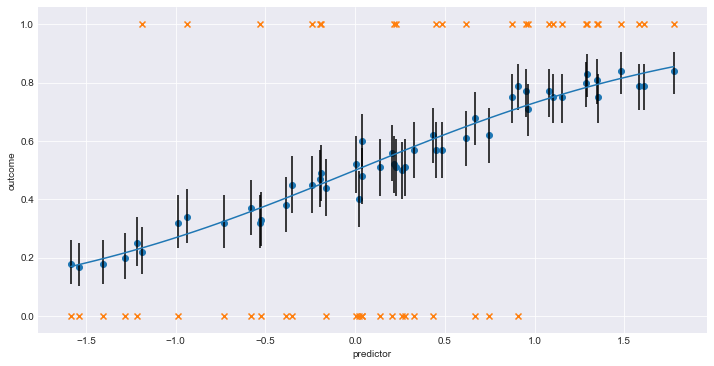

In [14]:
_, ax = plt.subplots(figsize=(12, 6))

β = st.beta((ppc['outcome'] == 1).sum(axis=0), (ppc['outcome'] == 0).sum(axis=0))

# estimated probability
ax.scatter(x=predictors_out_of_sample, y=β.mean())

# error bars on the estimate
plt.vlines(predictors_out_of_sample, *β.interval(0.95))

# actual outcomes
ax.scatter(x=predictors_out_of_sample, 
           y=outcomes_out_of_sample, marker='x')

# True probabilities
x = np.linspace(predictors_out_of_sample.min(), predictors_out_of_sample.max())
ax.plot(x, invlogit(x), linestyle='-')


ax.set_xlabel('predictor')
ax.set_ylabel('outcome');